In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import glob
import time
import cv2
import os

In [ ]:
# Donot use these cells
# Erythroblast (ERB)
# Immature Granulocytes (IG)
# Platelet (PLATELET)
# Band Neutrophils (BNE)
# Segmented Neutrophils (SNE)

In [3]:
! gdown https://drive.google.com/u/0/uc?id=1gSe7K_D3MKUsUCU2uRbTcXTmlSRVaAqh

Downloading...
From: https://drive.google.com/u/0/uc?id=1gSe7K_D3MKUsUCU2uRbTcXTmlSRVaAqh
To: /content/PBC_dataset_normal_DIB_cropped.zip
263MB [00:03, 71.8MB/s]


In [4]:
! unzip -qq PBC_dataset_normal_DIB_cropped.zip

In [5]:
! rm $(find ./PBC_dataset_normal_DIB_cropped -name *ERB*)
! rm $(find ./PBC_dataset_normal_DIB_cropped -name *IG*)
! rm $(find ./PBC_dataset_normal_DIB_cropped -name *PLATELET*)
! rm $(find ./PBC_dataset_normal_DIB_cropped -name *BNE*)
! rm $(find ./PBC_dataset_normal_DIB_cropped -name *SNE*)

In [ ]:
# ! rm -rf /content/PBC_dataset_normal_DIB_cropped/erythroblast
# ! rm -rf erythroblast
# ! rm -rf erythroblast

# ! rm -rf erythroblast


In [6]:
name_dict = {
        "BA": 1,
        "EO": 2,
        "MMY": 3,
        "MY": 3,
        "PMY": 3,
        "LY": 4,
        "MO": 5,
        "NEUTROPHIL": 6,
        
}


class_names = [
      "basophil","eosinophil",  "ig", "lymphocyte", "monocyte", "neutrophil"
]

In [7]:
freq_count = {}
for class_name in class_names:
  files = glob.glob("PBC_dataset_normal_DIB_cropped/" + class_name + "/*")
  for file in files:
    name = os.path.basename(file).split("_")[0]
    freq_count[name] = freq_count.get(name, 0) + 1

In [8]:
freq_count

{'BA': 1218,
 'EO': 3117,
 'LY': 1214,
 'MMY': 1015,
 'MO': 1420,
 'MY': 1137,
 'NEUTROPHIL': 50,
 'PMY': 592}

In [9]:
def parse_filepath(filepath):
    try:
        #path, filename = os.path.split(filepath)
        label = os.path.basename(filepath).split("_")[0]
        #filename, ext = os.path.splitext(filename)
        #label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [10]:
DATA_DIR = 'PBC_dataset_normal_DIB_cropped'
H, W, C = 360, 360, 3

In [11]:
files = glob.glob("{}/*/*.jpg".format(DATA_DIR))
print("Total files = ",len(files))

Total files =  9763


In [12]:
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df.head()

,label,file
0,NEUTROPHIL,PBC_dataset_normal_DIB_cropped/neutrophil/NEUT...
1,NEUTROPHIL,PBC_dataset_normal_DIB_cropped/neutrophil/NEUT...
2,NEUTROPHIL,PBC_dataset_normal_DIB_cropped/neutrophil/NEUT...
3,NEUTROPHIL,PBC_dataset_normal_DIB_cropped/neutrophil/NEUT...
4,NEUTROPHIL,PBC_dataset_normal_DIB_cropped/neutrophil/NEUT...


In [13]:
# Fixing random state for reproducibility
np.random.seed(19680801)

train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.8*len(df)), int(.9*len(df))])

In [14]:
print(len(train))
print(len(validate))
print(len(test))

7810
976
977


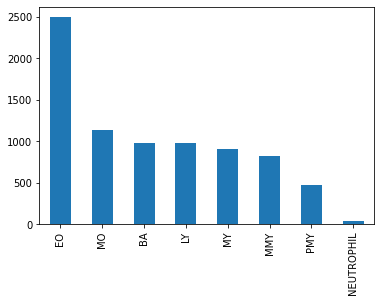

In [15]:
train['label'].value_counts().plot.bar()
plt.savefig("train_dist.jpg", bbox_inches='tight', pad_inches=0.1)
plt.savefig("train_dist.eps", bbox_inches='tight', pad_inches=0.1)

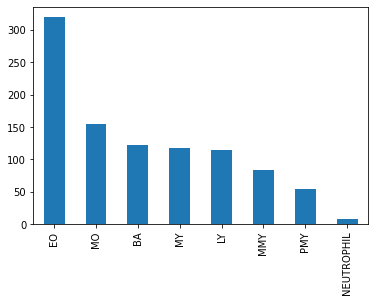

In [16]:
validate['label'].value_counts().plot.bar()

In [17]:
train.head()

,label,file
8372,LY,PBC_dataset_normal_DIB_cropped/lymphocyte/LY_3...
8756,BA,PBC_dataset_normal_DIB_cropped/basophil/BA_980...
360,MO,PBC_dataset_normal_DIB_cropped/monocyte/MO_762...
96,MO,PBC_dataset_normal_DIB_cropped/monocyte/MO_806...
1783,EO,PBC_dataset_normal_DIB_cropped/eosinophil/EO_7...


In [18]:
from keras_preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=360,
                            zoom_range=[0.9,1.0],
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.20,
                            horizontal_flip=True,
                            vertical_flip=True,
                            brightness_range=[0.8,1.0],
                            fill_mode="nearest")

In [19]:
batch_size=24

In [20]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/",
    x_col="file",
    y_col="label",
    seed=42,
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical",
    #save_to_dir="./train/",
    target_size=(H, W)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=validate,
    directory="/content/",
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    #save_to_dir="./validation/",
    target_size=(H,W)
)

Found 7810 validated image filenames belonging to 8 classes.
Found 976 validated image filenames belonging to 8 classes.


In [21]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

class_weights = {i : class_weights[i] for i in range(len(name_dict))}

print("Weights: ")

for cl, id in train_generator.class_indices.items():
  print(cl, class_weights[id])

Weights: 
BA 0.9931332655137335
EO 0.3915964701163257
LY 1.0012820512820513
MMY 1.192002442002442
MO 0.8608906525573192
MY 1.0859288097886541
NEUTROPHIL 25.03205128205128
PMY 2.0860042735042734


In [22]:
N_LABELS = len(name_dict)
D = 1

In [23]:
import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, \
                                    GlobalMaxPool2D, Dropout, SpatialDropout2D, add, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model


def Classification(H,W,C):
    
    input_layer = tf.keras.Input(shape=(H, W, C))

    m1_1 = BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="m1_1", padding='same')(input_layer))
    m1_2 = BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="m1_2", padding='same')(m1_1))
    m1_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="m1_3", padding='same')(m1_2)))

    l1_1 = BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="l1_1", padding='same')(m1_3))
    l1_2 = BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="l1_2", padding='same')(l1_1))
    l1_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(32, 3, activation='relu', strides=(1, 1), name="l1_3", padding='same')(l1_2)))

    m2_1 = BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="m2_1", padding='same')(l1_3))
    m2_2 = BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="m2_2", padding='same')(m2_1))
    m2_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="m2_3", padding='same')(m2_2)))

    l2_1 = BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="l2_1", padding='same')(m2_3))
    l2_2 = BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="l2_2", padding='same')(l2_1))
    l2_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(64, 3, activation='relu', strides=(1, 1), name="l2_3", padding='same')(l2_2)))


    m3_1 = BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="m3_1", padding='same')(l2_1))
    m3_2 = BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="m3_2", padding='same')(m3_1))
    m3_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="m3_3", padding='same')(m3_2)))

    l3_1 = BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="l3_1", padding='same')(m3_3))
    l3_2 = BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="l3_2", padding='same')(l3_1))
    l3_3 = MaxPool2D((2, 2))(BatchNormalization(axis=-1)(Conv2D(128, 3, activation='relu', strides=(1, 1), name="l3_3", padding='same')(l3_2)))

    m4_1 = BatchNormalization(axis=-1)(Conv2D(256, 3, activation='relu', strides=(2, 2), name="m4_1")(l3_3))
    m4_2 = BatchNormalization(axis=-1)(Conv2D(256, 3, activation='relu', strides=(2, 2), name="m4_2")(m4_1))
    # m4_3 = BatchNormalization(axis=-1)(Conv2D(512, 3, activation='relu', strides=(2, 2), name="m4_3")(m4_2))
    # m4_4 = BatchNormalization(axis=-1)(Conv2D(512, 3, activation='relu', strides=(2, 2), name="m4_4")(m4_3))


    #x = SpatialDropout2D(0.5, name="dropout_3")(m4_4)
    x = Flatten(name="flatten")(m4_2)
    x = Dense(512, activation='relu', name="dense_512")(x)
    x = Dense(N_LABELS, activation='softmax', name="output_layer")(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    return model


model = Classification(H,W,C)

opt = Adam(learning_rate=1e-5)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 3)]     0         
_________________________________________________________________
m1_1 (Conv2D)                (None, 360, 360, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 360, 360, 32)      128       
_________________________________________________________________
m1_2 (Conv2D)                (None, 360, 360, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 360, 360, 32)      128       
_________________________________________________________________
m1_3 (Conv2D)                (None, 360, 360, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 360, 360, 32)      128   

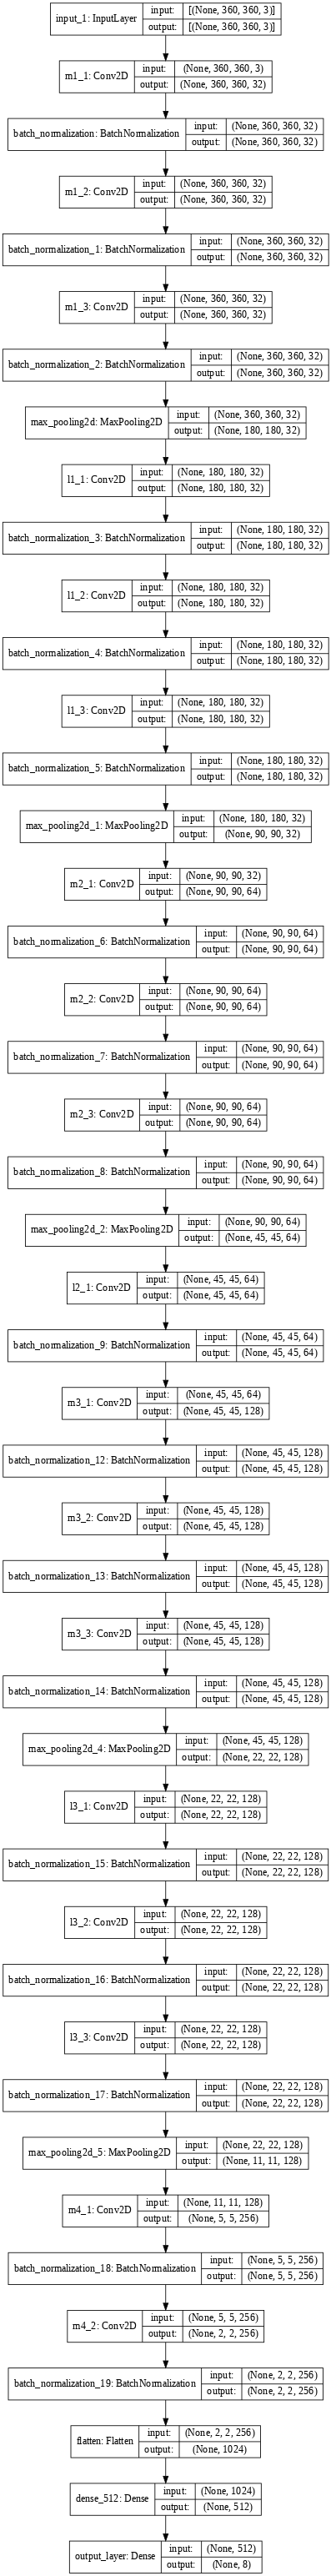

In [ ]:
from tensorflow.keras.utils import  plot_model as pm  #plotting the model structure
pm(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)
]
# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [26]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=4,
                    class_weight=class_weights,
                    callbacks=[tensorboard_callback,callbacks],
)

Epoch 1/4
325/325 [==============================] - 340s 936ms/step - loss: 2.4962 - accuracy: 0.1026 - val_loss: 2.1809 - val_accuracy: 0.1542
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 2/4
325/325 [==============================] - 303s 931ms/step - loss: 2.0075 - accuracy: 0.1994 - val_loss: 1.9360 - val_accuracy: 0.3187
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 3/4
325/325 [==============================] - 302s 930ms/step - loss: 1.6881 - accuracy: 0.3426 - val_loss: 1.6209 - val_accuracy: 0.4271
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 4/4
325/325 [==============================] - 302s 927ms/step - loss: 1.4436 - accuracy: 0.4657 - val_loss: 1.3656 - val_accuracy: 0.5135
INFO:tensorflow:Assets written to: ./model_checkpoint/assets


In [27]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'history_classification_model_10e.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

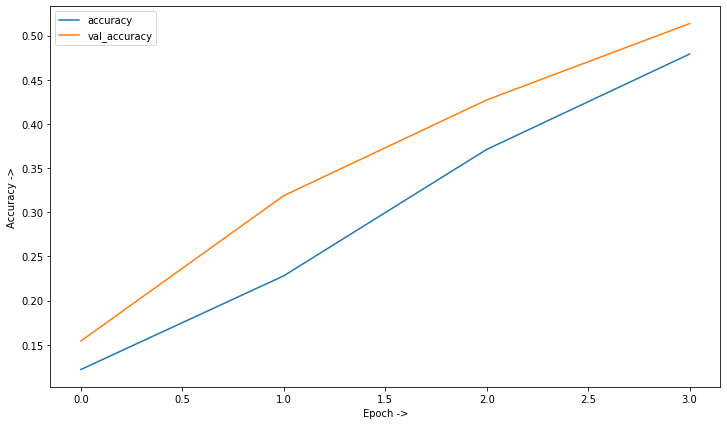

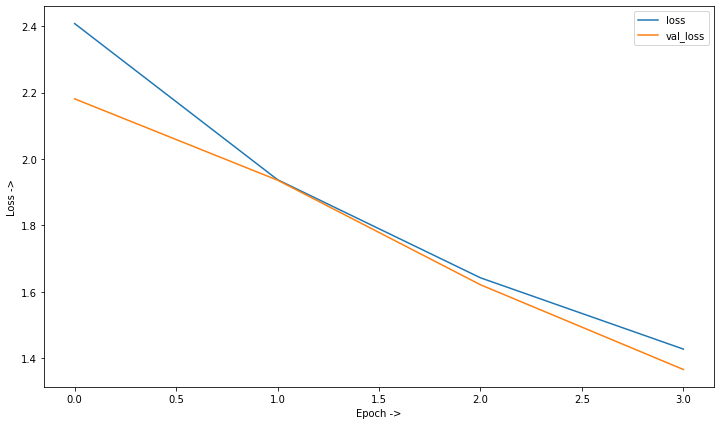

In [28]:
plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['accuracy']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper left')
plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()

In [29]:
model.save('classification_model_blood.h5')

In [30]:
from tensorflow import keras
model = keras.models.load_model('classification_model_blood.h5')

In [31]:
test_datagen=ImageDataGenerator(rescale=1./255.,
    rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory="/content/",
    x_col="file",
    y_col=None,
    batch_size=10,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(W,H)
)

Found 977 validated image filenames.


In [32]:
import math
STEP_SIZE_TEST=math.ceil(test_generator.n/test_generator.batch_size)

In [33]:
test_generator.reset()
pred = model.predict_generator(test_generator,
  steps=STEP_SIZE_TEST,
  verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


98/98 [==============================] - 27s 276ms/step


In [34]:
predicted_class_indices=np.argmax(pred,axis=1)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(len(predictions))

977


In [35]:
filenames=test_generator.filenames
print(len(filenames))
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

977


In [36]:
file = results.iloc[5]["Filename"]
test[test.file == file]["label"]

7970    LY
Name: label, dtype: object

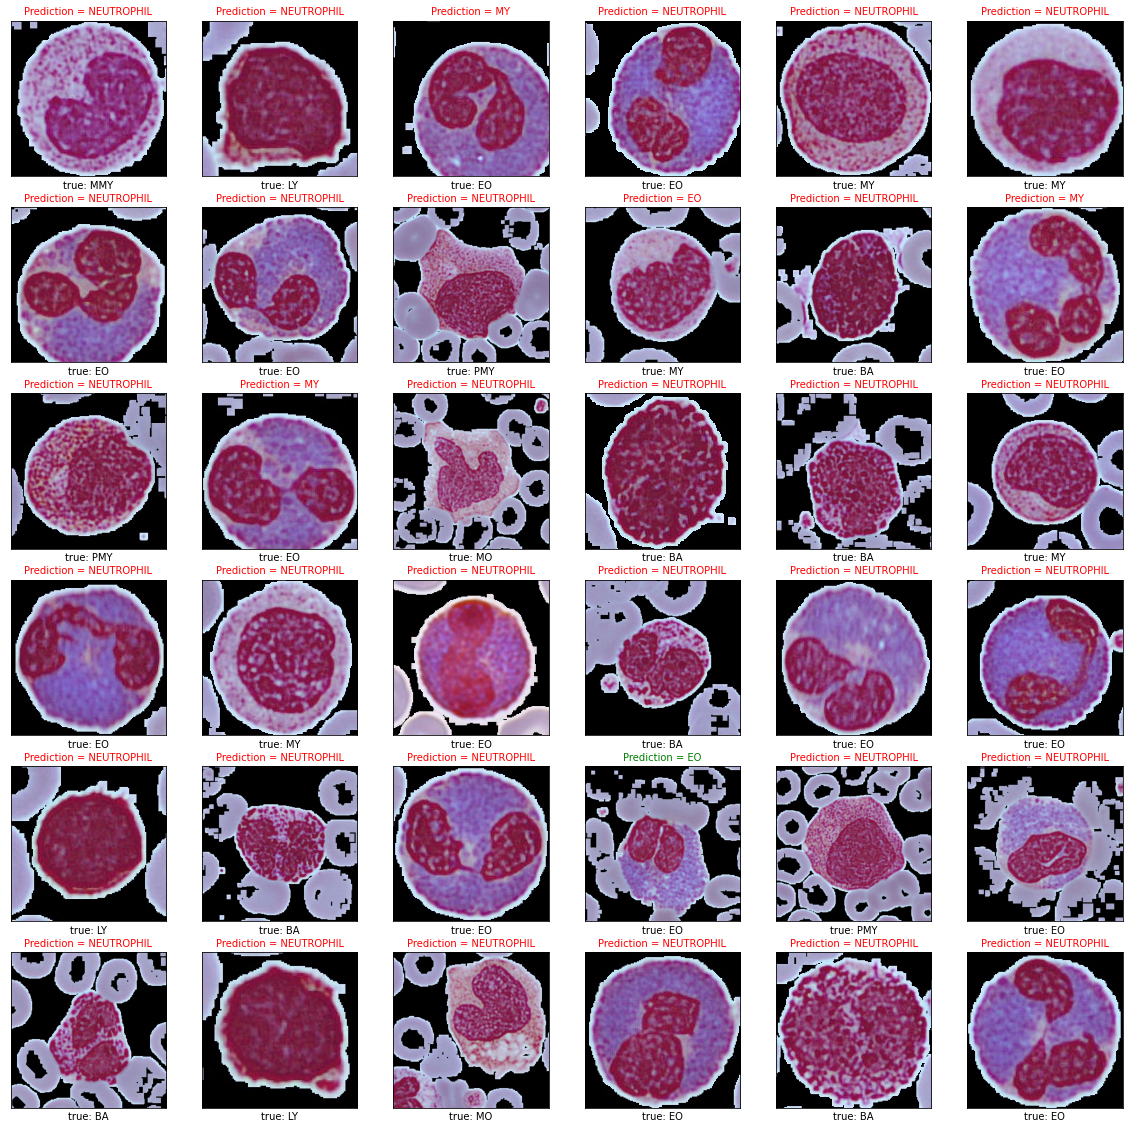

In [37]:
import math
n = 36
random_indices = np.random.permutation(n)
n_cols = 6
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    filename = results.iloc[img_idx]["Filename"]
    ax.imshow(cv2.imread(filename))
    actual_pred = results.iloc[img_idx]["Predictions"]
    true_val = parse_filepath(filename)
    if actual_pred == true_val:
        ax.set_title("Prediction = {}".format(actual_pred),fontsize=10).set_color('green')
    else:
        ax.set_title("Prediction = {}".format(actual_pred),fontsize=10).set_color('red')
    ax.set_xlabel('true: {}'.format(true_val),fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])